In [290]:
import pathlib

import gym
import torch

from matplotlib import pyplot as plt

In [291]:
ENV = 'Acrobot-v1'
RECORD_PATH = "../videos/reinforce/" + ENV

In [292]:
VIDEO_RECORD_DIR = pathlib.Path(RECORD_PATH)

In [293]:
env = gym.make(ENV, new_step_api=True)

In [378]:
class reinforce(torch.nn.Module):

    def __init__(self, policy: torch.nn.Module) -> None:
        super().__init__()
        self.policy = policy
    
    def forward(self, state):
        return self.policy(state)

class ActionReplayBuffer(torch.nn.Module):

    def __init__(self, gamma: float) -> None:
        super().__init__()
        self.gamma = gamma

        self.state_buffer = []
        self.action_buffer = []
        self.reward_buffer = []

    def __len__(self):
        return len(self.state_buffer)
    
    def push(self, state, action, reward):
        state = torch.FloatTensor(state).unsqueeze(dim=0)

        self.state_buffer.append(state)
        self.action_buffer.append(action)
        self.reward_buffer.append(reward)
    
    def sample(self):
        self.reward_buffer.reverse()

        for i in range(len(self.reward_buffer) - 1):
            self.reward_buffer[i + 1] = self.reward_buffer[i + 1] + ((self.gamma) * self.reward_buffer[i])

        self.reward_buffer.reverse()

        state_tensor = torch.cat(self.state_buffer)
        action_tensor = torch.tensor(self.action_buffer)
        reward_tensor = torch.FloatTensor(self.reward_buffer)

        return state_tensor, action_tensor, reward_tensor

    def empty(self):
        self.__init__(self.gamma)

def action_multinomial(action_probabilities):
    output = torch.distributions.Categorical(action_probabilities)
    return output.sample().item()

def reinforce_loss(prob_batch, expected_returns_batch):
    error = torch.log(prob_batch) * expected_returns_batch
    return -torch.sum(error)


In [383]:
MAX_EPISODE_STEPS = 200
MAX_EPISODES = 1000
GOAL_SCORE = 475

HIDDEN_SIZE = 64

LOG_TIME = 20

obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n

learning_rate = 0.00003
gamma = 0.99

In [389]:
def torch_reinforce_train(agent, replay_buffer, optimizer):
    score = []

    for trajectory in range(MAX_EPISODES + 1):
        state = env.reset()
        done = False
    
        for t in range(MAX_EPISODE_STEPS):
            torch_state = torch.from_numpy(state).float()

            state[-1] = state[-1] / 13
            state[-2] = state[-2] / 30

            action_probs = agent(torch_state)

            action = action_multinomial(action_probs)

            prev_state = state

            step_state = env.step(action)
            state, reward, done = step_state[0], step_state[1], step_state[2]

            replay_buffer.push(prev_state, action, reward)

            if done:
                break

        score.append(-len(replay_buffer))

        state_batch, action_batch, reward_batch = replay_buffer.sample()
        replay_buffer.empty()

        reward_batch = reward_batch / torch.abs(reward_batch).max()

        pred_batch = agent(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                 .long().view(-1,1)).squeeze()
    
        loss = reinforce_loss(prob_batch, reward_batch)

        # torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.5)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if trajectory % LOG_TIME == 0 and trajectory > 0:
            mean_score = sum(score[-LOG_TIME:-1]) / len(score[-LOG_TIME:-1])
            print('Trajectory {}\tAverage Score: {:.2f}\tLoss: {:.2f}'.format(trajectory, mean_score, loss.item()))

            if mean_score > GOAL_SCORE:
                break
    
    return score    

In [390]:
model = torch.nn.Sequential(
             torch.nn.Linear(obs_size, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
             torch.nn.ReLU(),
             torch.nn.Linear(HIDDEN_SIZE, n_actions),
             torch.nn.Softmax(dim=0)
    )

agent = reinforce(model)
replay_buffer = ActionReplayBuffer(gamma)

optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [391]:
score = torch_reinforce_train(agent, replay_buffer, optimizer)

Trajectory 20	Average Score: -200.00	Loss: -699.11
Trajectory 40	Average Score: -200.00	Loss: -699.19
Trajectory 60	Average Score: -200.00	Loss: -699.18
Trajectory 80	Average Score: -200.00	Loss: -699.20
Trajectory 100	Average Score: -200.00	Loss: -699.03
Trajectory 120	Average Score: -200.00	Loss: -699.17
Trajectory 140	Average Score: -200.00	Loss: -699.46
Trajectory 160	Average Score: -200.00	Loss: -699.33
Trajectory 180	Average Score: -200.00	Loss: -699.24
Trajectory 200	Average Score: -200.00	Loss: -699.24
Trajectory 220	Average Score: -200.00	Loss: -699.11
Trajectory 240	Average Score: -200.00	Loss: -699.07
Trajectory 260	Average Score: -200.00	Loss: -699.55
Trajectory 280	Average Score: -200.00	Loss: -699.80
Trajectory 300	Average Score: -200.00	Loss: -699.14
Trajectory 320	Average Score: -200.00	Loss: -699.41
Trajectory 340	Average Score: -200.00	Loss: -699.35
Trajectory 360	Average Score: -200.00	Loss: -699.05
Trajectory 380	Average Score: -200.00	Loss: -700.26
Trajectory 400	A

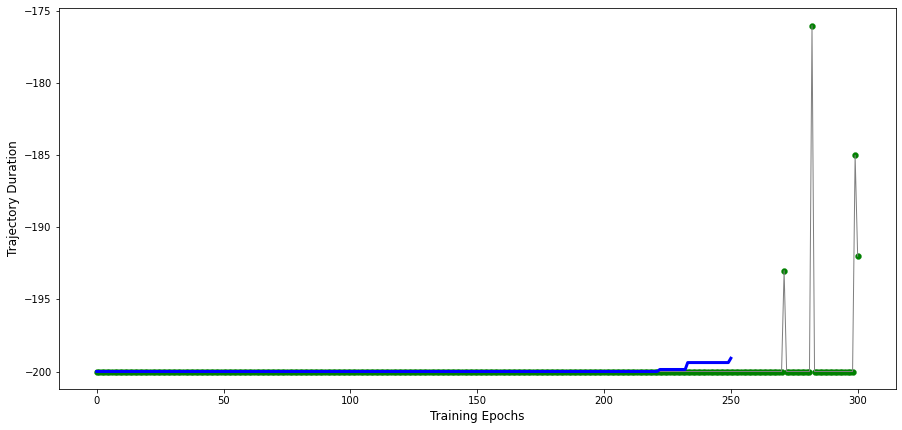

In [ ]:
def running_mean(x):
    N=50
    kernel = torch.ones(N)
    conv_len = x.shape[0]-N
    y = torch.zeros(conv_len)
    for i in range(conv_len):
        y[i] = torch.matmul(kernel, x[i:i+N].float())
        y[i] /= N
    return y

score = torch.tensor(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))

plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)

plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)

plt.scatter(torch.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)

In [245]:
from gym.wrappers import RecordVideo

def watch_agent(max_steps=500):
    env = gym.make(ENV, new_step_api=True)
    env = RecordVideo(env, video_folder=VIDEO_RECORD_DIR)
    state = env.reset()

    rewards = []

    for t in range(max_steps):
        pred = model(torch.from_numpy(state).float())
        action = torch.argmax(pred).item()

        step_state = env.step(action)
        state, reward, done = step_state[0], step_state[1], step_state[2]

        rewards.append(reward)

        if done:
            print("Reward:", sum([r for r in rewards]))
            break

    env.close()

In [246]:
watch_agent()

/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment Acrobot-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/Users/lulu/Worskpace/rl-journey/.venv/lib/python3.10/site-packages/gym/core.py:

Reward: -500.0
